**UNDER CONSTRUCTION**<br>
Version 27.08.2019, A. S. Lundervold.

# Introduction

This notebook goes through some core concepts related to **classification** in machine learning. It's based on the textbook's Chapter 3. See also Geron's notebook here: https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb. 

### Classification

In classification we want to decide which of N classes an input belongs to (think of the fish from the slides in the first lecture). We'll do this by training models on a set of examples of each class. 

Essentially, it's about finding a *good* function from the inputs $X$ to a set of labels: 

$$f: X \longrightarrow \{1, \dots, N\}.$$

Note that classification is a *discrete* problem: each input belongs to a class, and the set of classes cover all possibilities. 

It's one of the two main forms of **supervised learning**, the other one being **regression**.

### Regression

Regression is about finding a function that maps from the inputs to a *continuous* set of numbers:

$$f: X \longrightarrow \mathbb{R}.$$

Think of the housing prices prediction from assignment 1, where you're constructing a function mapping from a set of features of a housing district to the price of a house in that district. Or, more generally, say you have a set of $x$-values (inputs) and corresponding outputs as real numbers ($y$-values). When given a new, previously unseen $x$-value, what $y$-value should you predict? What is the best interpolating function? 

### Classification or regression?

How do you decide whether you have a classification or a regression problem? Ask yourself
> Is there continuity on the possible predictions?

Predicting a price of 1.500.000 versus 1.500.001 makes a very small difference, suggesting that you're faced with a regression problem. Predicting that an image contains object number 12 versus object number 13 likely makes a huge difference, and you should probably treat this as a classification problem.

# Setup

In [1]:
# To automatically reload modules defined in external files
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

We import our standard framework:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

# The data: MNIST

We'll base our discussion on a famous benchmark dataset: **MNIST**

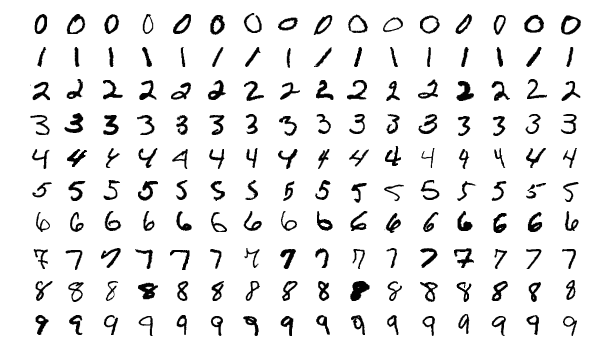

In [3]:
import IPython
IPython.display.Image('assets/MnistExamples.png', width='90%')

It consists of 70.000 examples of handwritten digits. MNIST has been called "the machine learning equivalent of fruit flies": it's simple, but not too simple, and is very well-studied. Have a look at https://en.wikipedia.org/wiki/MNIST_database and http://yann.lecun.com/exdb/mnist/ for more details.

Our goal is to construct a system that can take an image from MNIST as input and produce the correct digit 0, ..., 9 as output. This is a multi-class system.

<centering>
<img src="assets/goal.png">
</centering>

Correctly classifying handwritten digits is a difficult problem.. Can you come up with features that characterizes all the number 2's, but none of the other digits? How can you program rules that detect only 2's?

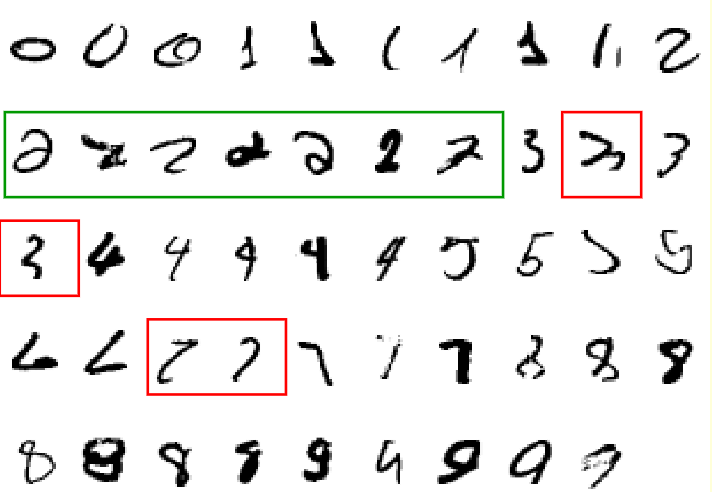

In [4]:
import IPython
IPython.display.Image('assets/mnist-difficult.png', width='90%')

<span style="font-size:smaller">Image from G. Hinton's Coursera course [Neural Networks for Machine Learning](https://www.coursera.org/learn/neural-networks)</span>

# Download the data

[OpenML](https://www.openml.org/) is a convenient source of machine learning data, containing MNIST among many other standard data sets. Scikit-learn has a method we can use to fetch data from OpenML:

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', version=1, data_home='./data')

This gives us a Python dictionary containing the data, labels and a description of the data set:

In [7]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [8]:
#print(mnist.DESCR)

Each of the 70.000 images are of size 28*28 = 784, stored as Numpy arrays:

In [9]:
mnist.data.shape

(70000, 784)

In [10]:
type(mnist.data)

numpy.ndarray

In [11]:
mnist.target.shape

(70000,)

In [12]:
X = mnist.data
y = mnist.target

# Creating training and test sets

After collecting the data, the first step is to set aside a test set. The data in the test set will not be used for anything else than the final test of our machine learning model's accuracy. Using the test set during model design is a huge no-no since this will give a biased performance estimate when evaluating our model on the test set (i.e. we'll overfit to the test data set). 

> We're not interested in how well our models perform on the training set, what we're really after is how well they generalize to unseen data. 

The test set is meant to simulate unseen data (and should therefore not be touched when constructing and tuning our models). 

<img width=50% src="assets/testsplit.png"> 

We'll use the first 60.000 images as our training data and the last 10.000 as test (this is the standard split for MNIST):

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Inspect the data

As always, we should take a look at the training data. Having a feeling for the variation and quality of the data, and the difficulty of the task, is crucial for constructing machine learning models. When dealing with images it's of course convenient to plot them.

In [14]:
some_digit = X_train[34500]

The images are vectors of length 784:

In [15]:
some_digit.shape

(784,)

To plot them we reshape to 28*28:

In [16]:
some_digit_image = some_digit.reshape(28,28)

Here's a small section of the image:

In [17]:
some_digit_image[15:20,15:20]

array([[ 19., 218., 231.,   9.,   0.],
       [  0.,  48., 254., 168.,   0.],
       [  0.,   7., 210., 232.,   0.],
       [  0.,  13., 222., 232.,   0.],
       [  3., 105., 254., 191.,   0.]])

The numbers represent grayscale values.

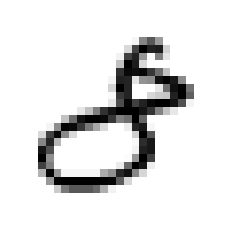

In [18]:
# Plot the image using a grayscale colormap
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()

Let's make a small convenience function to plot MNIST images:

In [19]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=matplotlib.cm.binary)
    plt.axis("Off")

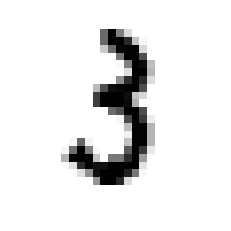

In [20]:
plot_digit(X_train[1234])

...and plot a random selection:

In [21]:
import random

In [22]:
nb=10
to_plot = random.choices(X_train, k=nb)

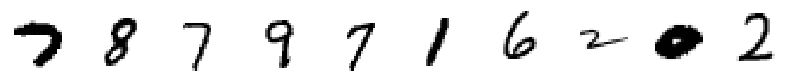

In [23]:
f = plt.figure(figsize=(14,14))
for i in range(nb):
    plt.subplot(1,nb,i+1)
    plot_digit(to_plot[i])
plt.show()

> **Your turn!** Make a function that plots a random selection of images from a specified class. For example `plot_images(image_class='8', nb=25)` should plot 25 random 8's from the training data:

<img src="assets/plot_images.png">

You'll want to create such small throwaway helper functions all the time when you're investigating a new data set.

# A binary classifier

Following the textbook, we start by constructing a binary classifier: a system that aims to distinguish 5's from non-5's. This makes things a bit easier, and will also help illustrate some important concepts.

In [24]:
y_train_5 = (y_train == '5') # True if the label is 5, else False
y_test_5 = (y_test == '5')

## Training a model

We have a lot of choices when building our model, something we'll learn more about in Part 3 of the course. For now, let's use `SGDClassifier` as a "black box", without studying how it works behind the scenes (but feel free to read more about the model [here](http://scikit-learn.org/stable/modules/sgd.html)). Our focus now is on classification in general, not on specific models. 

In [25]:
from sklearn.linear_model import SGDClassifier

In [26]:
#?SGDClassifier

In [27]:
# Create an instance of the model:
sgd_clf = SGDClassifier()

In [28]:
# Train the model:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

The model is now trained on the training data, and we can use it to predict whether a digit is a 5 or not:

In [29]:
def predict_image(img):
    
    # Plot the input image
    plot_digit(img)
    plt.title("Input image")
    plt.show()
    
    # Produce and print prediction
    pred = sgd_clf.predict([img])
    print(f"Prediction: {pred}")

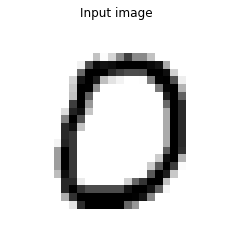

Prediction: [False]


In [30]:
predict_image(X_test[10])

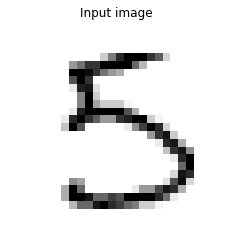

Prediction: [ True]


In [31]:
predict_image(X_test[15])

By experimenting with various input images you'll notice that the model is correct some times, incorrect others. 
> **How good is the model, really?** 

We need ways to evaluate and validate models..

# Evaluating models / performance measures

First of all, when evaluating the performance of a model one should really ask "*What is the end goal for my system"?* We're supposed to create systems that are useful in some context, as part of a larger system, which typically has a higher-level goal that our system should aim to optimize. Perhaps it's worth sacrificing accuracy for speed, or not getting a lot of useless clicks that don't lead to sales?

However, we won't think about these broader context matters in this toy problem.

## Accuracy and different sorts of errors

For classification a common metric is accuracy: what fraction of our predictions were correct? 

But there are different kinds of errors in binary classification: if we classify something as belonging to the positive class we can either be correct (**true positive**) or incorrect (**false positive**). If we classify something as negative we can either be correct (**true negative**) or incorrect (**false negative**). 

What types of errors we care most about depends on the task: if we're for example diagnosing a treatable condition in patients we should do everything we can to reduce the rate of false negatives. While perhaps still keeping an eye on the false positive rate because a positive diagnosis could lead to invasive and extensive further testing for the patient.

In spam filtering we care most about not marking important emails as spam, i.e. we want a low false positive rate (non-spam marked as spam) even if it means a higher false negative rate (some spam emails ending up in our inbox). 

## Validation set and model selection

We're now going to play around with different models and their "settings" (i.e. changeable parameters) to decide which model to use. This is called "model selection". 


It's very important to *not* base these decisions on test set performance. Otherwise we'll have no way to produce an unbiased estimate of how well the final model will generalize to new data, as we've used information from our test set to design the model.

We can deal with this issue by splitting the training set into two: a data set used for training (still called the training set) and a data set for evaluating performance while trying out various possible models and settings, called a **validation set**.

We've seen this idea used earlier in the course, and we know how to do this using the `train_test_split` function.

> **Your turn!**
- Split `(X_train, y_train_5)` into two parts: one for training, one for validation. You can call the new data sets and label sets `X_train_new, X_val, y_train_5_new, y_val_5`
- Train your model again on the new training set, and compute its accuracy on the validation set using the `score` method: `model.score(X_val, y_val_5)` 
- Is the result good? What accuracy would a random guesser have?
- Play around with some of the parameters of `SGDClassifier` and try to improve the result on the validation set. Once you've found some parameters that seem good, test on the test set: `model.predict(X_test)` and `model.score(X_test, y_test_5)` (If you want to be thorough, use grid search to test parameter combinations).

## Cross-validation

Another frequently used way to do validation is *cross-validation*.

The idea is to randomly split the training set into several parts, so called *folds*. Say into K folds, for example. Then train a model K times, each time using a different fold for evaluation and training on the remaining K-1. The average score for the K runs is used to estimate the model's performance. 

This means that *each sample in the training set is part of the training set K-1 times and the evaluation set once*. 

<img src="assets/K-fold_cross_validation_EN.jpg"><br>
<span style="font-size:70%">Image from <a href="https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.jpg">Wikipedia</a></span>

An important advantage of this approach over the one above is that it doesn't waste as much training data. Unless you have plenty of data, cross-validation is the preferred method for estimating model performance.

Cross-validation also provides a more thorough test than splitting the data into a training set and a test set. The `train_test_split` procedure sets aside a fixed random subset of the data as a test set. If we're unlucky, all the difficult examples end up in the training set, while the test set contains only easy ones. That would lead to an overestimate of the true performance of our model.

Note: the special case of cross-validation where K is set to the number of data points in the training set is called *leave-one-out*. Each fold is then a single sample.

The result of this K-fold cross validation procedure is an array of K evaluation scores.

> We'll use the cross-validation approach in the rest of this notebook. 

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
cv_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring='accuracy')

In [34]:
print(cv_scores)

[0.96341972 0.96725    0.96916667 0.94983333 0.96408034]


In [35]:
cv_scores.mean()

0.9627500110104167

The mean accuracy of our model on the five folds is about 96%, which on the surface looks pretty good!

...but is it really? Remember, there are 10 digits in MNIST, with approximately equal number of images from each class. A subset of the data is therefore expected to contain roughly 10% 5's and 90% non-5's. We're dealing with a highly **unbalanced dataset** (also called a *skewed dataset*). In such cases accuracy is typically not a very informative measure.

A model that's always predicting non-5's will have an accuracy of approximately 90%. That makes our model less impressive...

Luckily, there's a better way to evaluate the model than merely computing the accuracy!

## Confusion matrix

A confusion matrix is a table summarizing the results from a classification model's predictions. In what way is the classifier "confused"? What errors does it tend to make?

The idea is to simply count the number of times instances of a certain class is classified as the various classes in your problem. In our case, how often the 4s and non-5s are correctly classified, how often a 5 is misclassified as a non-5 and how often a non-5 is misclassified as a 5.

We need some produce some predictions to compare with the true classes. We can use `cross_val_predict`, which works similarly to `cross_val_score` except that it returns predictions based on all the K folds.

In [36]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

We now want to compare...

In [37]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

...to

In [38]:
y_train_5

array([ True, False, False, ...,  True, False, False])

Here's the confusion matrix:

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[52004  2575]
 [  780  4641]]


Let's use a small function for creating slightly nicer plots of confusion matrices, adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html. Don't worry about the details of this function now (unless you want to). 

In [41]:
import itertools

def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    Adapted from  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

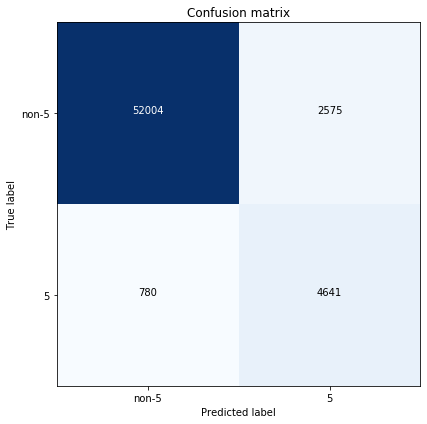

In [42]:
_ = plot_confusion_matrix(cm, classes=["non-5", '5'])

Each row in the matrix represents a class: non-5s and 5s. Each column represents a predicted class. 

The first row tells us that more than 50.000 images were correctly classified as non-5s (**true negatives**). There were 500-1000 images classified as 5s that where really non-5s (**false positives**).

The second row tells us that about 1000+ 5s were wrongly labelled as non-5s (**false negatives**), while the remaining 5s were correctly classified (**true positives**). 

> **Your turn!** How would the confusion matrix of a perfect classifier be?

These numbers tell us a lot about classifier performance. But sometimes it's useful to quantify (i.e. compute numbers) how much our classifier deviates from a perfect classifier.

## Precision, recall and specificity

For binary classification problems, i.e. where there are only two possible classes, we can use **precision**, **recall** and **specificity**.

It's helpful to first introduce some notation:

- P = All positive data points
- N = All negative data points
- TP = True positives
- FP = False positives
- TN = True negatives
- FN = False negatives

> **Your turn!** What are the values of these numbers for the classifier above?

The **precision** of a binary classifier is **the proportion of the positive predictions that were actually correct**. In other words, 

$$precision = \frac{\mbox{true positives}}{\mbox{positive predictions}} = \frac{TP}{TP + FP}.$$

> **Your turn!** What's the precision of the classifier above (hint: the answer is approximately 0.75)? What's the precision of a _perfect_ classifier? If a classifier has perfect precision, is it necessarily a good classifier?

The **recall** of a binary classifier is **the proportion of actual positives that were correctly identified**. In other words, 

$$recall = \frac{\mbox{true positives}}{\mbox{all actual positives}} = \frac{TP}{P} = \frac{TP}{TP+FN}$$

Recall is sometimes also called the **true positive rate**.

> **Your turn!** What's the recall of the classifier above (hint: the answer is approximately 0.8)? What's the recall of a _perfect_ classifier? If a classifier has perfect recall, is it necessarily a good classifier?

The **specificity** of a binary classifier is **the proportion of actual negatives that were correctly identified**. In other words,

$$specificity = \frac{\mbox{true negatives}}{\mbox{all actual negatives}} = \frac{TN}{TN + FP}$$

Specificity is sometimes also called the **true negative rate**.

> **Your turn!** What's the specificity of the classifier above (hint: the answer is approximately 0.75)? What's the specificity of a _perfect_ classifier? If a classifier has perfect specificity, is it necessarily a good classifier?

![](assets/Precisionrecall.svg.png)

<span style=font-size:80%>Illustration from Wikipedia</span>

### Connection to the confusion matrix

If you think about it for a bit, it's clear that these numbers are closely connected to the confusion matrix:

![](./assets/cm_illustration.png)

<span style=font-size:80%>Illustration from the textbook</span>

We can use this connection to compute the precision, recall and sensitivity:

In [43]:
cm

array([[52004,  2575],
       [  780,  4641]])

In [44]:
# Here's a way to pick out elements of a two-dimensional array
cm[0][0]

52004

In [45]:
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

In [46]:
tn, fp, fn, tp

(52004, 2575, 780, 4641)

In [47]:
#..or slightly more conveniently:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(52004, 2575, 780, 4641)

In [48]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
sensitivity = tn / (tn + fp)

In [49]:
print(f"Precision: {precision}\n Recall: {recall}\n Sensitivity: {sensitivity}")

Precision: 0.6431541019955654
 Recall: 0.8561151079136691
 Sensitivity: 0.9528206819472691


### In scikit-learn

Of course, scikit-learn has this functionality built-in

In [50]:
from sklearn.metrics import precision_score, recall_score

In [51]:
precision_score(y_train_5, y_train_pred)

0.6431541019955654

In [52]:
recall_score(y_train_5, y_train_pred)

0.8561151079136691

> **Your turn!** What is more important, high precision or high recall?

> **Your turn!** A question to ponder: How would you define precision and recall if you have more than two classes?

## $F_1$ score

Since you typically care about both precision and recall, it can sometimes make sense to combine them into one number (for example when comparing two classifiers). The **$F_1$ score** is one way, defined as a sort of average of precision and recall. Not the usual average, but what's called the *harmonic mean*:

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

You may wonder why you would use the harmonic mean instead of the standard (arithmetic) mean. The main reason is that we want to output a low score for a classifier that has either very bad precision or very bad recall (i.e. one of them close to 0). Such classifiers should be punished by assigning them a very low score. 

For example, if the precision is 0.0001 and the recall is 1, the $F_1$ score will be close to 0, while the artihmetic mean would be (0.0001 + 1) / 2 ~ 0.5. 

> **Your turn!** Say you have two classifiers A and B, with

$$
\begin{align}
\mbox{precision}_A = 0.7,\quad &\mbox{recall}_A = 0.6 \\
\mbox{precision}_B = 0.3,\quad &\mbox{recall}_B = 1
\end{align}
$$

> What are the corresponding arithmetic means of the two models? What are their $F_1$ scores? You'll notice that model B's bad precision results in a lower $F_1$ compared to model A.

In [53]:
from sklearn.metrics import f1_score

In [54]:
f1_score(y_train_5, y_train_pred)

0.7345097728891351

An $F_1$ score of 1.0 means perfect precision *and* perfect recall (i.e. a perfect classifier).

## Precision/recall tradeoff

Importantly, **it's typically impossible to achieve both high precision and high recall simultaneously**. They are typically competing quantities: when one is high the other os low. Working to improve the precision often lowers the model's recall, and vice-versa. You have to trade one for the other.

Let's try to understand why

A classifier with perfect recall is easy to construct: just predict that everything is a 5! Then there are no false negatives and the recall is 1.0. Perfect. Except, the precision will be rubish.

To get high precision, make a classifier predict *one* 5 that you're very sure is correct, and the rest as non-5s. Then the number of false positives will likely be 0, and the precision 1.0. The recall will however be really bad as there will be many false negatives. 

We can see this principle in action for our `SGDClassifier`. But we'll have to discuss what's going on behind the scenes when we ran `sgd_cl.fit` on our training data...

_Fitting_ or _training_ the `SGDClassifier` means finding a _hyperplane_, or a _boundary_, in the data space that separates the 5s from the non-5s as much as possible. 

When feeding `SGDClassifer` a data point it decides whether it is a 5 or a non-5 bassed on the _distance_ from the data point to this hyperplane. By default, if the data point has a negative distance to the plane, the model predicts that it's from the negative class (a non-5 in our case). If the distance is positive, it's predicted to be from the positive class (a 5). In other words, the **decision threshold** is set to 0 by default. 

Furthermore, the distance from the data point to the hyperplane can be interpreted as how _certain_ the model is about its prediction. The larger the distance, the more certain the model. 

***Where you set theis threshold makes a big difference***. We can see this visually here (figure from the textbook): 

![](assets/precisionrecalltradeoff.png)

...and do some experiments on an example to investigate further:

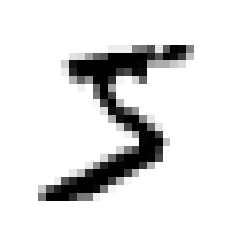

In [55]:
plot_digit(X_train[0])

`SGDClassifier` has a method that computes the distance of a data point from the hyperplane:

In [56]:
y_example_score = sgd_clf.decision_function([X_train[0]])

In [57]:
print(y_example_score)

[798.81793826]


Let's play with the threshold:

In [58]:
threshold = 0
y_example_pred = (y_example_score > threshold)
print(f"Is it a 5? {y_example_pred}")

Is it a 5? [ True]


In [59]:
threshold = 5000
y_example_pred = (y_example_score > threshold)
print(f"Is it a 5? {y_example_pred}")

Is it a 5? [False]


You can see that increasing the threshold for classifying something as a 5 makes the model less likely to do so. *This increases the precision of the classifier, but reduces its recall.* Lowering the threshold has the opposite effect: higher recall, lower precision.

Let's plot this.

First we compute the decision function score for all the training data:

In [60]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=2, method='decision_function')

We get 60.000 scores, one for each training example:

In [61]:
y_scores.shape

(60000,)

Now, let's compute and plot the precisions and recalls for various thresholds:

In [62]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

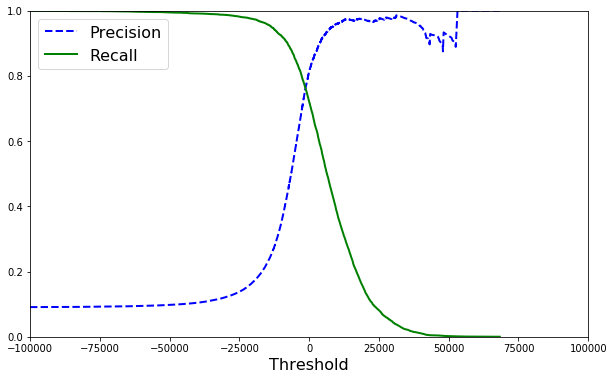

In [63]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-100000, 100000])
plt.show()

Using such plots it's possible to select the threshold value that gives the best precision/recall tradeoff for your task.

Are false negatives very bad (like in medical diagnosis)? Select a low threshold to get high recall and OK precision. Are false positives especially costly (like in spam detection)? Go for a threshold that gives you high precison and OK recall.

Note that it's very easy to create a classifier with any precision you want, as long as you don't care about recall. You just have to select a suitable threshold. 

For example

In [64]:
y_train_pred_precise = (y_scores > 20000)
precision_score(y_train_5, y_train_pred_precise)

0.9717586649550706

In [65]:
recall_score(y_train_5, y_train_pred_precise)

0.13964213244788784

As Geron puts it:

> If someone says "let's reach 90% precision!", you should ask, "at what recall?"

## ROC curves

A **ROC curve** (or **receiver operating characteristic curve**) is a graph that's often used to evaluate binary classifiers. It's a plot of the true positive rate (i.e. the recall) versus the false positive rate:

$$
TPR = \frac{TP}{TP + FN}
FNR = \frac{FP}{FP + TN}
$$

We can compute the TPR and FPR for various thresholds using the `roc_curve` function:

In [66]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

...and plot the ROC curve:

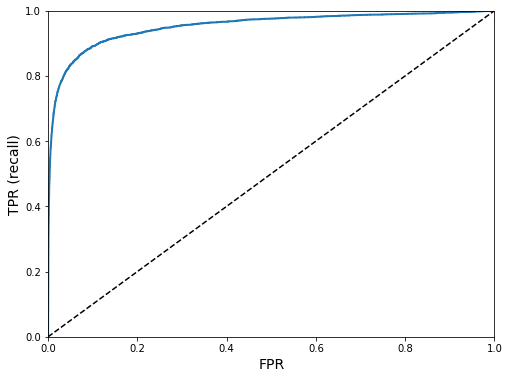

In [67]:
def plot_roc_curve(fpr, tpr):
    f = plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=14)
    plt.ylabel('TPR (recall)', fontsize=14)
    
plot_roc_curve(fpr, tpr)
plt.show()

A really good classifier will have a ROC curve that's very close to the top left corner (high TPR and low FPR for any thresholds), while a completely random classifier will be close to the dotted line (as many true positives as false positives for any threshold).

We can use such ROC curves to compute how good a classifier is: if it's really good then the area under the curve will be high (i.e. close to the maximum area which is 1). If it's really bad (i.e. random) the area will be close to 0.5. This is called the **ROCAUC**, the *ROC area under the curve*.

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9522833665129677

Is this a good score? Well, not really. There are very few 5's compared to non-5's which means that a classifier that tends to predict 5's too rarely (i.e. low recall) still gets a seemingly okay ROC curve. In cases where you have an imbalanced dataset plotting the precision versus the recall can give you more information:

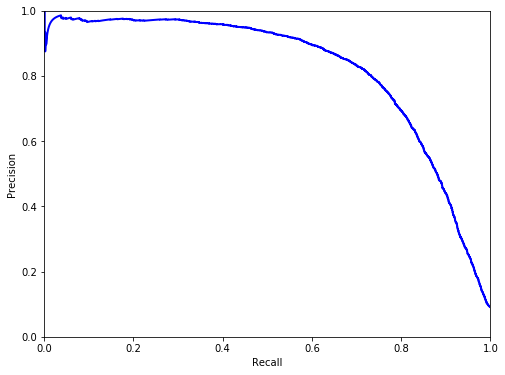

In [69]:
def plot_precision_vs_recall(precisions, recalls):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(recalls, precisions, "b-", linewidth=2)
    plt.setp(ax, xlabel="Recall", ylabel="Precision")
    plt.axis([0, 1, 0, 1])
    return ax
    
_ = plot_precision_vs_recall(precisions, recalls)

What you really want are classifiers whose precisiom-recall curve goes to the far upper right-hand corner. High precision and high recall. We notice that in this case we can get a recall of about 0.8 while still having an OK precision. Higher than that then the precision drops quickly.

## Comparing classifiers

The metrics we've discussed above gives us ways to compare classifiers. We can for example use the ROC curve and the ROCAUC. 

We can try this out by creating another model to solve our classification task: a random forest:

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Get predictions
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                   cv=3, method='predict_proba')


In [71]:
y_probas_forest.shape

(60000, 2)

In [72]:
# The scores are the probabilities of the positive class assigned by the model
y_scores_forest = y_probas_forest[:, 1]

# Compute the FPR and TPR
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

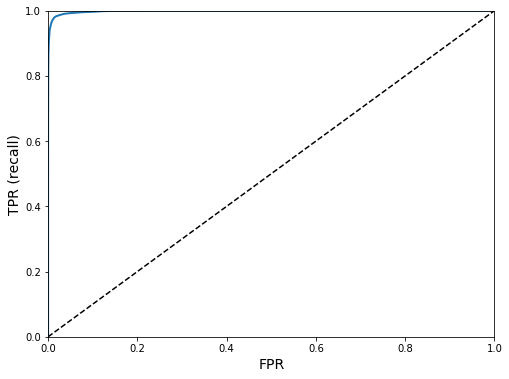

In [73]:
plot_roc_curve(fpr_forest, tpr_forest)

We get:

In [74]:
print(f"ROCAUC for SGDClassifier: {roc_auc_score(y_train_5, y_scores)}\n")
print(f"ROCAUC for RandomForestClassifier: {roc_auc_score(y_train_5, y_scores_forest)}")

ROCAUC for SGDClassifier: 0.9522833665129677

ROCAUC for RandomForestClassifier: 0.9983436731328145


This leads us to prefer the random forest model (unless of course other considerations besides what's captured by the ROCAUC pulls in the direction of the SGDClassifier...).

Let's also have a look at the models' precision-recall curves:

In [75]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

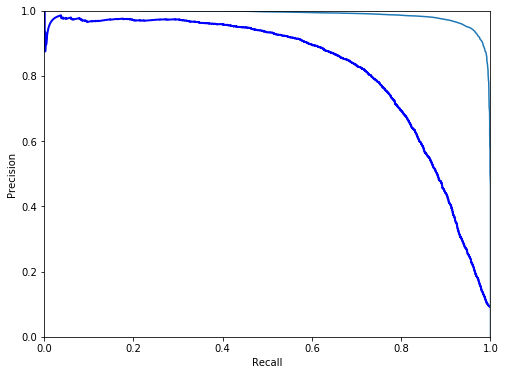

In [76]:
ax = plot_precision_vs_recall(precisions, recalls)
ax.plot(precisions_forest, recalls_forest)
plt.show()

This also leads us to prefer the random forest (we can get higher precisions at higher recall compared to the SGDClassifier). 

Analogous to what we did for the ROC curve, we can compute the area under the precision-recall curve. This is called *average precision*, and is also commonly used to assess model performance. 

Computing such numbers are often more convenient than looking at curves, and also enables automatic model selection.

In [77]:
from sklearn.metrics import average_precision_score

aps_sgd = average_precision_score(y_train_5, y_scores)
aps_rf = average_precision_score(y_train_5, y_scores_forest)

In [78]:
print(f"The average precision of SGDClassifier is: {aps_sgd:.3f}\n")
print(f"The average precision of RF is: {aps_rf:.3f}\n")

The average precision of SGDClassifier is: 0.821

The average precision of RF is: 0.988



We also see that, unsurprisingly, the accuracy of the random forest is way higher than the SGD classifier. But also that the random forest is much slower in producing its predicitons...

In [79]:
%%time 
cross_val_score(forest_clf, X_train, y_train_5, cv=3).mean()

CPU times: user 1min 3s, sys: 1.04 s, total: 1min 4s
Wall time: 1min 3s


0.9871666666666666

In [80]:
%%time 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3).mean()

CPU times: user 39.1 s, sys: 908 ms, total: 40 s
Wall time: 37.9 s


0.95185

## Summary so far

Some of the things we've learned so far:

- How to train a binary classifier
- Choosing appropriate metrics for the task
- Evaluating classifiers using cross-validation
- Selecting appropriate precision/recall tradeoffs
- Comparing models using ROC curves and ROCAUC scores

# Multiclass model: detecting more than 5s

Now that we've seen some of the major concepts and techniques in classification, let's try to predict something that's more difficult: all the 10 classes in MNIST.

The ideas behind multiclass predictions are the same, but the difficulty for our models are increased. 

Scikit-learn takes care of adapting models for multi-class predictions:

In [89]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

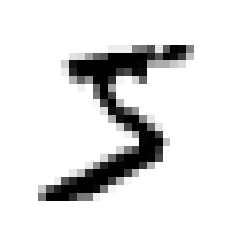

In [123]:
some_digit = X_train[0]
plot_digit(some_digit)

In [124]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Behind the scenes, scikit-learn trained 10 binary classifiers for us, and used them all on the `some_digit` data point. The class whose decision score was the highest was outputted by `predict`:

In [125]:
sgd_clf.decision_function([some_digit])

array([[-14587.44886943, -38794.46606822,  -9299.39285482,
          3074.73424782, -28427.52419687,   2246.82640232,
        -25706.03160794, -23594.27838235, -10399.32605252,
        -13510.13107227]])

In [126]:
np.argmax(sgd_clf.decision_function([some_digit]))

3

We can do the same with random forest classifiers:

In [127]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['5'], dtype=object)

We can get the list of probabilities that the random forest assigned to each class:

In [128]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

...and notice that the fifth class (corresponding to 5s) got assigned the highest probability.

## Evaluation

### Cross-validation

In [95]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.85867826, 0.86369318, 0.88608291])

In [96]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.96620676, 0.96339817, 0.96714507])

### Confusion matrix


Let's compare the two classifiers' confusion matrices:

In [97]:
sgd_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=-1)

In [98]:
sgd_cm = confusion_matrix(y_train, sgd_train_pred)
forest_cm = confusion_matrix(y_train, forest_train_pred)

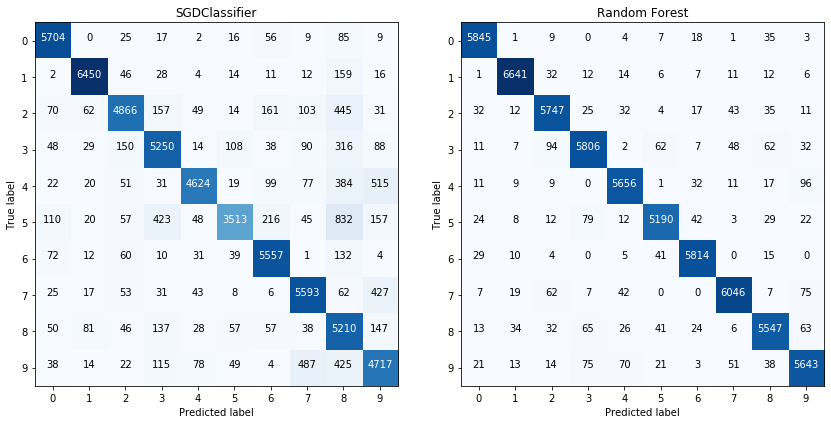

In [99]:
cms = [sgd_cm, forest_cm]
titles = ["SGDClassifier", "Random Forest"]
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for i, ax in enumerate(axes.flat):
    plot_confusion_matrix(cms[i], classes=sgd_clf.classes_, ax=ax, title=titles[i])

Bot confusion matrices look pretty good: most of the images land on the diagonal. However, there are errors and there seems to be some patterns in them... Let's take a closer look.

> As a side note: these are not the kinds of models you would use for computer vision problems these days. You've heard of **"deep learning"** and the **revolution** it has caused in machine learning during the last couple of years. Where it started, and where it's made the most impact until now, is in computer vision. In the last part of the course we'll have a look at deep learning, and study models that can quite easily reach above 99.7% accuracy on MNIST. Which means that the model makes a mistake on *less than 30 images of the 10.000 test images*! And for some of these images, if we take a look ourself, we would agree with the machine's predictions. Modern deep learning has blown away MNIST as a benchmark by essentially "solving" it. We'll have a quick look at deep learning methods later. And if you come back for [DAT255](https://www.hvl.no/en/studies-at-hvl/study-programmes/course/dat255) you'll learn all about it...

## Error analysis

We can zoom in on the errors in the confusion matrices by disregarding the main diagonal. First we have to scale each value by the number of images in the corresponding class, to properly compare error rates:

In [100]:
row_sums = sgd_cm.sum(axis=1, keepdims=True)
norm_sgd_cm = sgd_cm / row_sums

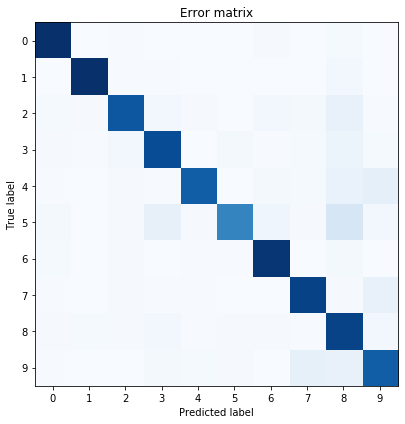

In [101]:
_ = plot_confusion_matrix(norm_sgd_cm, classes=sgd_clf.classes_, 
                         title="Error matrix", labels=False)

We notice several interesting things:
- Bright columns for 8 and 9 --> many images get misclassified as 8 or 9s.
- Bright rows for 8 and 9 --> many 8s and 9s are often confused with other digits
- The model confuses for example 7s with 9s and 3s with 5s

This gives us some ideas for improving our model. Perhaps we should try to improve the 8 and 9 classifications, and work to fix the 3/5 confusion.

### Analyzing individual errors

Let's plot some 3s and 5s. Some 3s that the model got correct, some it confused for 5s. Some 5s the confused for 3s, and some correct 5s. 

In [118]:
# Taken from the book:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [119]:
def individual_errors(clf, cl_a, cl_b):
    cl_a, cl_b = str(cl_a), str(cl_b)
    X_aa = X_train[(y_train == cl_a) & (sgd_train_pred == cl_a)] # Correct class a's
    X_ab = X_train[(y_train == cl_a) & (sgd_train_pred == cl_b)] # a's predicted as b's
    X_ba = X_train[(y_train == cl_b) & (sgd_train_pred == cl_a)] # b's predicted as a's
    X_bb = X_train[(y_train == cl_b) & (sgd_train_pred == cl_b)] # Correct b's
    
    plt.figure(figsize=(10,10))
    plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
    plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
    plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
    plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

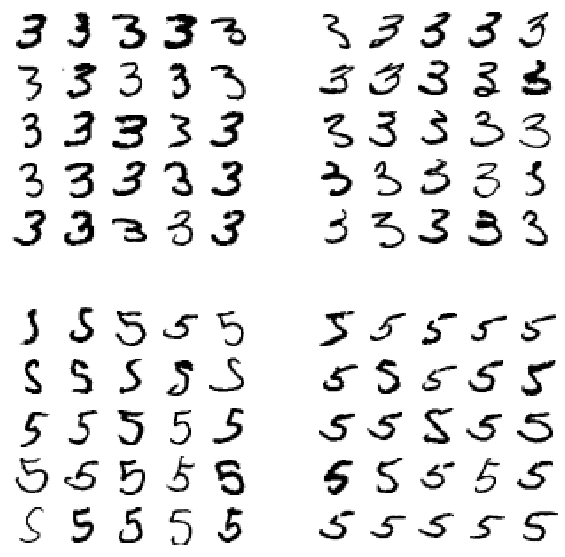

In [120]:
individual_errors(sgd_clf, 3, 5)

The SGDClassifier is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the wighted pixel intensities to get a score for each class. Since 3s and 5s only differ only by a few pixels, this model will easily confuse them. Same for 7s and 9s:

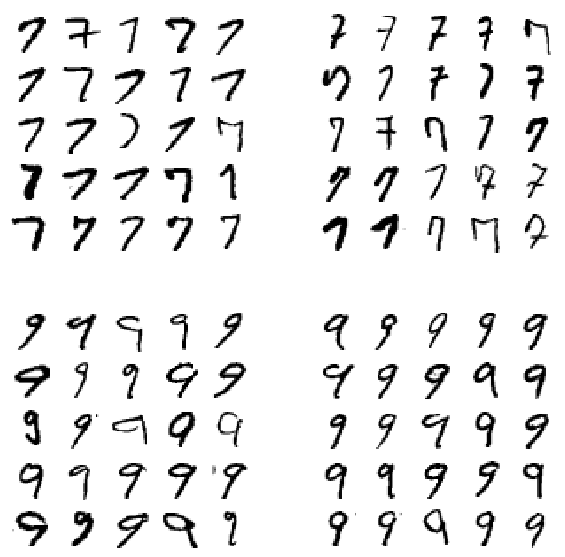

In [121]:
individual_errors(sgd_clf, 7, 9)

One would expect it to perform better on for example 1s and 4s:

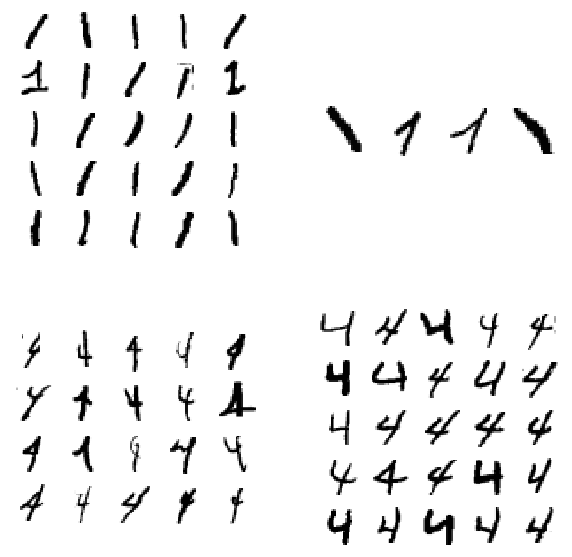

In [122]:
individual_errors(sgd_clf, 1, 4)

# End

Now you've learned about some of the main practical machine learning ideas and techniques, and you're actually already well-equipped to go out and attack real-world problems.

However, we've treated the models as black boxes. **We haven't really discussed how machine learning models work!** It's important to know some of the how's to be an effective machine learning practitioner.

In Part 3 we'll start to dig deeper. How are the models constructed? How are they trained?